Economic Risk Assessment System
Analyzes economic risk based:
• Short-term debt cycles (business cycles)
• Long-term debt cycles (generational debt patterns)
• Productivity metrics (human capital & investment)
• Economic momentum and trend analysis

Ray Dalio Economic Risk Assessment System
Country Analysis: Sample Country
Data loaded for 15 years: 2010-2024
Short-term debt cycle: 15 observations
Long-term debt cycle: 15 observations
Human capital index: 15 observations
Capital formation: 15 observations

Calculating Ray Dalio Risk Assessment...
------------------------------------------------------------
Risk assessment completed
Average risk probability: 36.5%
Risk threshold: 50.0%
High risk years: 2/15

INVESTMENT FORECAST:
Based on Ray Dalio's economic framework analysis for Sample Country, the investment recommendation is BUY with 62.7% probability of positive returns due to favorable economic conditions with manageable risk.
Recommendation: BUY
Investment Probability: 62.7%

RISK

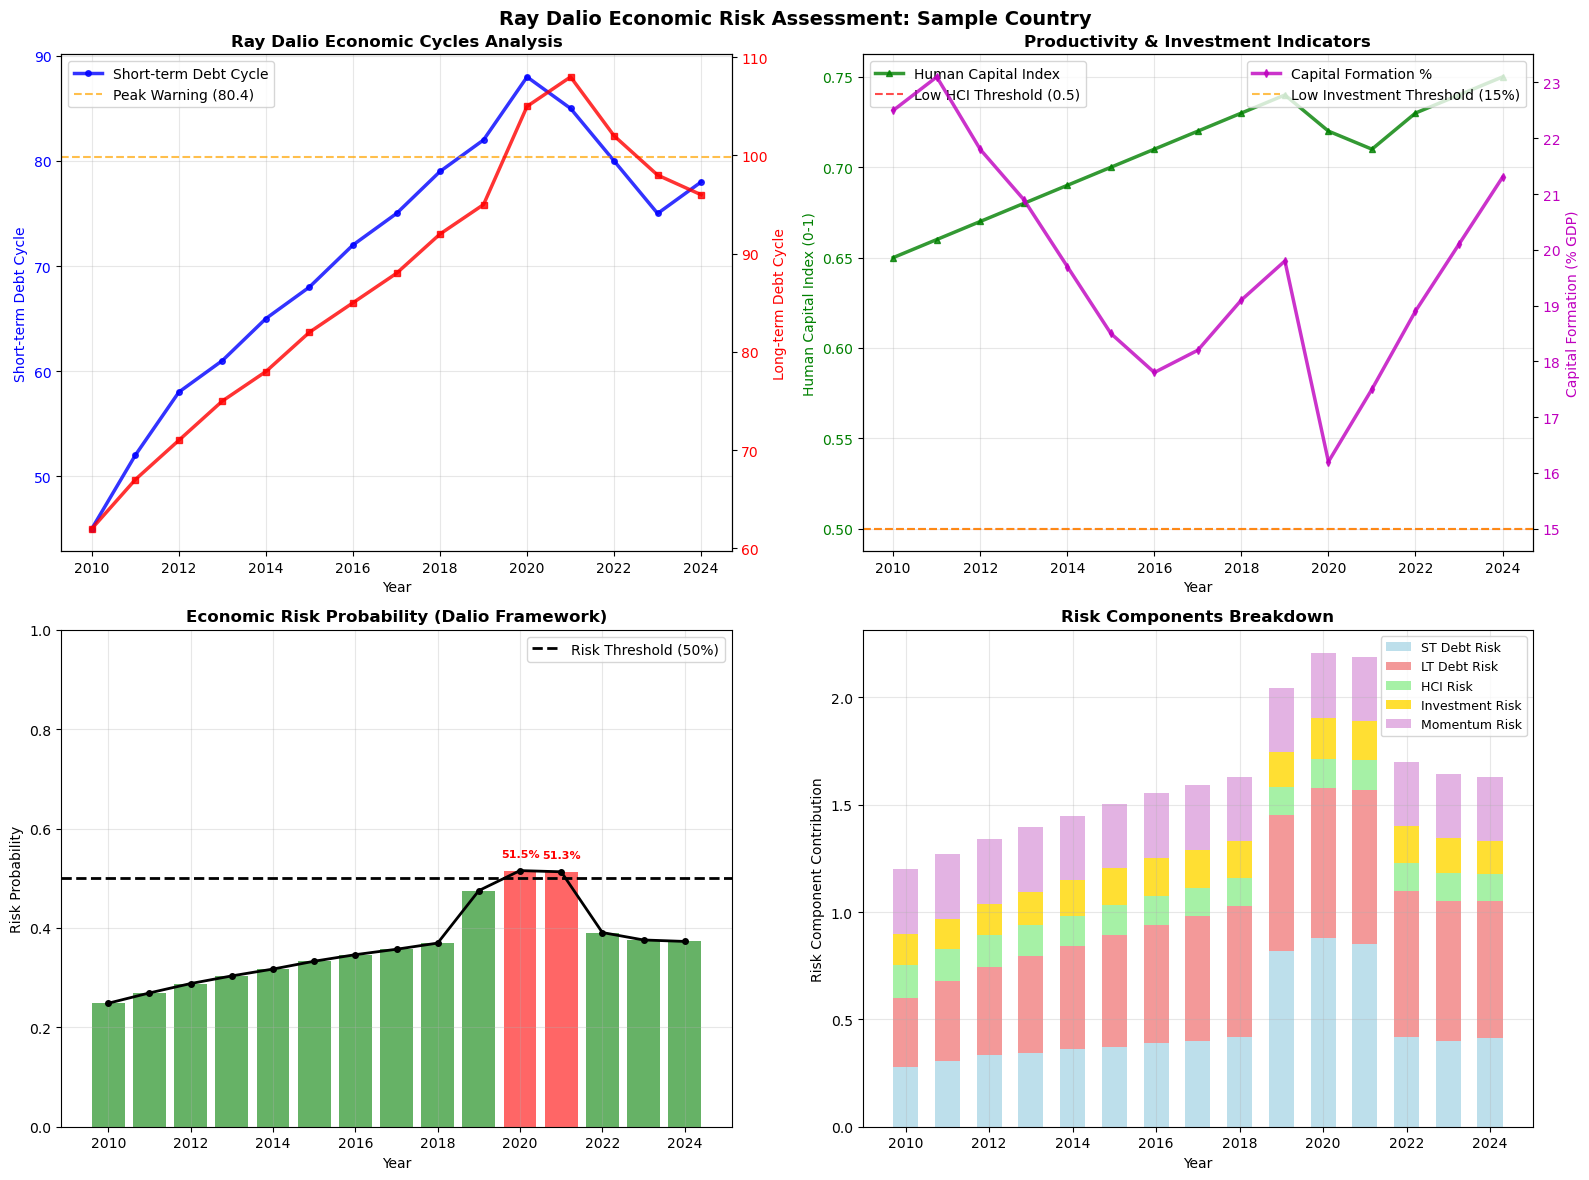


 FRAMEWORK INSIGHTS:
------------------------------------------------------------
Analysis Period: 2010-2024
High Risk Years: 2 years - [2020, 2021]
Low Risk Years: 13 years - [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2022, 2023, 2024]

RISK FACTOR CORRELATIONS:
----------------------------------------
Short_Term_Debt_Cycle    : +0.909
Long_Term_Debt_Cycle     : +0.906
Human_Capital_Index      : +0.678
Capital_Formation_PCT    : -0.737

ECONOMIC REGIME ASSESSMENT:
----------------------------------------
Average Risk Level: 36.5%
Risk Volatility: 8.2%
Economic Regime: LOW RISK REGIME - Stable economic fundamentals

 INVESTMENT STRATEGY RECOMMENDATIONS:
------------------------------------------------------------
GROWTH STRATEGY (Pro-cyclical Positioning):
   • 60% Stocks (growth + value)
   • 20% Long-term bonds
   • 10% Emerging markets
   • 5% REITs/Real assets
   • 5% Commodities

MODEL VALIDATION & ASSUMPTIONS:
--------------------------------------------------


In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class EconomicRiskAnalysis:
    def __init__(self, country_name="Country"):
        self.country_name = country_name
        self.short_term_debt = None
        self.long_term_debt = None
        self.human_capital_index = None
        self.capital_formation = None
        self.risk_probability = None
        self.binary_forecast = None
        self.risk_components = {}
        self.data_years = None
        
        # Economic Framework Thresholds
        self.thresholds = {
            'debt_to_gdp_critical': 90,      # Critical debt level (Reinhart-Rogoff threshold)
            'debt_growth_warning': 0.15,      # 15% annual debt growth warning
            'productivity_decline': -0.05,    # 5% productivity decline warning
            'human_capital_low': 0.5,         # Below 0.5 HCI considered low
            'capital_formation_low': 15,      # Below 15% GFCF considered low
            'debt_service_critical': 20,      # 20% of GDP in debt service
            'cycle_peak_warning': 0.8,        # 80th percentile for cycle peaks
        }
        
        print(f"Country Analysis: {self.country_name}")
        print("="*80)
    
    def load_country_data(self, short_term_debt_data, long_term_debt_data, 
                         human_capital_data, capital_formation_data):
        """        
        Parameters:
        - short_term_debt_data: dict {year: debt_value} - Short-term debt cycle data
        - long_term_debt_data: dict {year: debt_value} - Long-term debt cycle data  
        - human_capital_data: dict {year: hci_value} - Human Capital Index (0-1 scale)
        - capital_formation_data: dict {year: gfcf_value} - Gross Fixed Capital Formation (% GDP)
        """
        
        # Get all years from all datasets
        all_years = set()
        for data in [short_term_debt_data, long_term_debt_data, human_capital_data, capital_formation_data]:
            all_years.update(data.keys())
        
        self.data_years = sorted(all_years)
        
        # Convert to pandas series with consistent indexing
        self.short_term_debt = pd.Series([short_term_debt_data.get(year, np.nan) for year in self.data_years], 
                                        index=self.data_years, name='Short-term Debt Cycle')
        
        self.long_term_debt = pd.Series([long_term_debt_data.get(year, np.nan) for year in self.data_years], 
                                       index=self.data_years, name='Long-term Debt Cycle')
        
        self.human_capital_index = pd.Series([human_capital_data.get(year, np.nan) for year in self.data_years], 
                                           index=self.data_years, name='Human Capital Index')
        
        self.capital_formation = pd.Series([capital_formation_data.get(year, np.nan) for year in self.data_years], 
                                         index=self.data_years, name='Capital Formation')
        
        print(f"Data loaded for {len(self.data_years)} years: {min(self.data_years)}-{max(self.data_years)}")
        print(f"Short-term debt cycle: {self.short_term_debt.dropna().count()} ")
        print(f"Long-term debt cycle: {self.long_term_debt.dropna().count()} ")
        print(f"Human capital index: {self.human_capital_index.dropna().count()} ")
        print(f"Capital formation: {self.capital_formation.dropna().count()} ")
    
    def calculate_dalio_risk_score(self):
        """
        Calculate probability score based on economic framework
        Key Risk Factors:
        1. Debt Cycle Position - Where are we in short/long-term cycles?
        2. Debt Sustainability - Can the debt be serviced?
        3. Productivity Growth - Is the economy becoming more productive?
        4. Human Capital - Quality of workforce and institutions
        5. Investment Rate - Is the country investing in future growth?
        """
        
        print("\nCalculating Risk Assessment...")
        print("-" * 60)
        
        risk_scores = []
        
        for year in self.data_years:
            # Get current year data
            st_debt = self.short_term_debt.get(year, np.nan)
            lt_debt = self.long_term_debt.get(year, np.nan) 
            hci = self.human_capital_index.get(year, np.nan)
            capform = self.capital_formation.get(year, np.nan)
            
            year_risk = 0.0
            risk_factors = {}
            
            # 1. SHORT-TERM DEBT CYCLE RISK (Weight: 25%)
            if not np.isnan(st_debt):
                # Normalize short-term debt cycle (assuming it's already a cycle indicator)
                st_debt_normalized = min(max(st_debt, 0), 100) / 100
                
                if st_debt_normalized > self.thresholds['cycle_peak_warning']:
                    st_risk = 0.8 + 0.2 * (st_debt_normalized - 0.8) / 0.2  # High risk near peaks
                elif st_debt_normalized < 0.2:
                    st_risk = 0.3 + 0.2 * (0.2 - st_debt_normalized) / 0.2  # Risk at troughs (deflationary)
                else:
                    st_risk = 0.1 + 0.4 * st_debt_normalized  # Moderate risk in middle
                
                year_risk += st_risk * 0.25
                risk_factors['short_term_debt'] = st_risk
            
            # 2. LONG-TERM DEBT CYCLE RISK (Weight: 30%)
            if not np.isnan(lt_debt):
                # Assess long-term debt sustainability
                lt_debt_normalized = min(max(lt_debt, 0), 150) / 150  # Cap at 150% of GDP
                
                if lt_debt_normalized > 0.6:  # Above 90% debt-to-GDP (Dalio's danger zone)
                    lt_risk = 0.6 + 0.4 * (lt_debt_normalized - 0.6) / 0.4
                elif lt_debt_normalized > 0.4:  # 60-90% debt-to-GDP (warning zone)
                    lt_risk = 0.3 + 0.3 * (lt_debt_normalized - 0.4) / 0.2
                else:  # Below 60% debt-to-GDP (safe zone)
                    lt_risk = 0.1 + 0.2 * lt_debt_normalized / 0.4
                
                year_risk += lt_risk * 0.30
                risk_factors['long_term_debt'] = lt_risk
            
            # 3. PRODUCTIVITY RISK - Human Capital Index (Weight: 20%)
            if not np.isnan(hci):
                # emphasizes human capital as key to long-term prosperity
                if hci < self.thresholds['human_capital_low']:
                    hci_risk = 0.8 - 0.6 * (hci / self.thresholds['human_capital_low'])
                else:
                    hci_risk = 0.2 - 0.15 * ((hci - self.thresholds['human_capital_low']) / 
                                           (1 - self.thresholds['human_capital_low']))
                
                year_risk += hci_risk * 0.20
                risk_factors['human_capital'] = hci_risk
            
            # 4. INVESTMENT/PRODUCTIVITY RISK - Capital Formation (Weight: 15%)
            if not np.isnan(capform):
                # Investment rate critical for future productivity (Dalio's emphasis)
                if capform < self.thresholds['capital_formation_low']:
                    capform_risk = 0.7 - 0.5 * (capform / self.thresholds['capital_formation_low'])
                else:
                    capform_risk = 0.2 - 0.15 * ((capform - self.thresholds['capital_formation_low']) / 
                                               max(35 - self.thresholds['capital_formation_low'], 1))
                
                year_risk += capform_risk * 0.15
                risk_factors['capital_formation'] = capform_risk
            
            # 5. TREND/MOMENTUM RISK (Weight: 10%)
            # Assess if trends are deteriorating (Dalio's focus on trend changes)
            momentum_risk = 0.3  # Base momentum risk
            
            # Check for deteriorating trends in recent years
            if year >= min(self.data_years) + 2:  # Need at least 3 years of data
                prev_years = [y for y in self.data_years if y < year][-2:]  # Last 2 years
                
                # HCI trend
                if len(prev_years) >= 2 and not np.isnan(hci):
                    hci_trend = (hci - self.human_capital_index.get(prev_years[0], hci)) / max(2, year - prev_years[0])
                    if hci_trend < -0.02:  # Declining human capital
                        momentum_risk += 0.3
                
                # Capital formation trend  
                if len(prev_years) >= 2 and not np.isnan(capform):
                    capform_trend = (capform - self.capital_formation.get(prev_years[0], capform)) / max(2, year - prev_years[0])
                    if capform_trend < -2:  # Declining investment
                        momentum_risk += 0.2
            
            year_risk += min(momentum_risk, 1.0) * 0.10
            risk_factors['momentum'] = min(momentum_risk, 1.0)
            
            # Store risk components for this year
            self.risk_components[year] = risk_factors
            
            # Ensure risk score is between 0 and 1
            year_risk = min(max(year_risk, 0.0), 1.0)
            risk_scores.append(year_risk)
        
        # Create probability series
        self.risk_probability = pd.Series(risk_scores, index=self.data_years, name='Risk Probability')
        
        # Generate binary forecast using adaptive threshold
        avg_risk = self.risk_probability.mean()
        threshold = max(0.5, avg_risk)  # Adaptive threshold, minimum 0.5
        
        self.binary_forecast = pd.Series(
            ['High Risk' if score >= threshold else 'Low Risk' for score in risk_scores],
            index=self.data_years, name='Risk Forecast'
        )
        
        print(f"Average risk probability: {avg_risk:.1%}")
        print(f"Risk threshold: {threshold:.1%}")
        print(f"High risk years: {sum(self.binary_forecast == 'High Risk')}/{len(self.binary_forecast)}")
    
    def generate_investment_forecast(self):
        """
        Generate a single sentence binary forecast with probability for investment potential
        """
        
        if self.risk_probability is None:
            raise ValueError("Risk assessment not calculated. Run calculate_dalio_risk_score() first.")
        
        latest_year = max(self.data_years)
        latest_risk = self.risk_probability.iloc[-1]
        latest_forecast = self.binary_forecast.iloc[-1]
        
        # Calculate investment potential (inverse of risk)
        investment_potential = 1 - latest_risk
        
        # Determine investment recommendation
        if investment_potential >= 0.7:
            recommendation = "STRONG BUY"
            rationale = "excellent economic fundamentals and low systemic risk"
        elif investment_potential >= 0.5:
            recommendation = "BUY"
            rationale = "favorable economic conditions with manageable risk"
        elif investment_potential >= 0.3:
            recommendation = "HOLD"
            rationale = "mixed economic signals requiring cautious approach"
        else:
            recommendation = "AVOID"
            rationale = "high systemic risk and structural economic challenges"
        
        forecast_sentence = (f"Based on economic framework analysis for {self.country_name}, "
                           f"the investment recommendation is {recommendation} with {investment_potential:.1%} "
                           f"probability of positive returns due to {rationale}.")
        
        return {
            'forecast_sentence': forecast_sentence,
            'recommendation': recommendation,
            'investment_probability': investment_potential,
            'risk_level': latest_forecast,
            'year': latest_year
        }
    
    def generate_summary_table(self):    
        if self.risk_probability is None:
            raise ValueError("Risk assessment not calculated. Run calculate_dalio_risk_score() first.")
            summary_df = pd.DataFrame({
            'Year': self.data_years,
            'Short_Term_Debt_Cycle': self.short_term_debt.values,
            'Long_Term_Debt_Cycle': self.long_term_debt.values,
            'Human_Capital_Index': self.human_capital_index.values,
            'Capital_Formation_PCT': self.capital_formation.values,
            'Risk_Probability': self.risk_probability.values,
            'Binary_Forecast': self.binary_forecast.values
        })
        
        # Add risk component breakdown
        for year in self.data_years:
            year_idx = self.data_years.index(year)
            components = self.risk_components.get(year, {})
            
            summary_df.loc[year_idx, 'ST_Debt_Risk'] = components.get('short_term_debt', np.nan)
            summary_df.loc[year_idx, 'LT_Debt_Risk'] = components.get('long_term_debt', np.nan)
            summary_df.loc[year_idx, 'HCI_Risk'] = components.get('human_capital', np.nan)
            summary_df.loc[year_idx, 'CapForm_Risk'] = components.get('capital_formation', np.nan)
            summary_df.loc[year_idx, 'Momentum_Risk'] = components.get('momentum', np.nan)
        
        return summary_df
    
    def plot_dalio_analysis(self, figsize=(16, 10)):
        if self.risk_probability is None:
            raise ValueError("Risk assessment not calculated. Run calculate_dalio_risk_score() first.")
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # 1. Main Economic Cycles Plot (Top Left)
        ax1 = axes[0, 0]
        
        # Plot the three main series
        if not self.short_term_debt.isna().all():
            ax1.plot(self.data_years, self.short_term_debt.values, 'b-o', 
                    linewidth=2.5, markersize=4, label='Short-term Debt Cycle', alpha=0.8)
        
        if not self.long_term_debt.isna().all():
            ax1_twin = ax1.twinx()
            ax1_twin.plot(self.data_years, self.long_term_debt.values, 'r-s', 
                         linewidth=2.5, markersize=4, label='Long-term Debt Cycle', alpha=0.8)
            ax1_twin.set_ylabel('Long-term Debt Cycle', color='brown')
            ax1_twin.tick_params(axis='y', labelcolor='brown')
        
        # warning thresholds
        if not self.short_term_debt.isna().all():
            peak_threshold = np.percentile(self.short_term_debt.dropna(), 80)
            ax1.axhline(y=peak_threshold, color='black', linestyle='--', alpha=0.7, 
                       label=f'Peak Warning ({peak_threshold:.1f})')
        
        ax1.set_title(' Economic Cycles Analysis', fontsize=12)
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Short-term Debt Cycle', color='black')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.legend(loc='upper left')
        
        # 2. Productivity Indicators (Top Right)
        ax2 = axes[0, 1]
        
        if not self.human_capital_index.isna().all():
            ax2.plot(self.data_years, self.human_capital_index.values, 'g-^', 
                    linewidth=2.5, markersize=5, label='Human Capital Index', alpha=0.8)
            # Add HCI warning threshold
            ax2.axhline(y=self.thresholds['human_capital_low'], color='black', linestyle='--', 
                       alpha=0.7, label=f'Low HCI Threshold ({self.thresholds["human_capital_low"]})')
        
        if not self.capital_formation.isna().all():
            ax2_twin = ax2.twinx()
            ax2_twin.plot(self.data_years, self.capital_formation.values, 'm-d', 
                         linewidth=2.5, markersize=4, label='Capital Formation %', alpha=0.8)
            ax2_twin.axhline(y=self.thresholds['capital_formation_low'], color='orange', 
                           linestyle='--', alpha=0.7, 
                           label=f'Low Investment Threshold ({self.thresholds["capital_formation_low"]}%)')
            ax2_twin.set_ylabel('Capital Formation (% GDP)', color='black')
            ax2_twin.tick_params(axis='y', labelcolor='black')
            ax2_twin.legend(loc='upper right')
        
        ax2.set_title('Productivity & Investment Indicators', fontsize=12)
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Human Capital Index (0-1)', color='brown')
        ax2.tick_params(axis='y', labelcolor='brown')
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)
        
        # 3. Risk Probability Evolution (Bottom Left)
        ax3 = axes[1, 0]
        
        # Risk probability with color coding
        colors = ['black' if forecast == 'High Risk' else 'green' for forecast in self.binary_forecast.values]
        ax3.bar(self.data_years, self.risk_probability.values, color=colors, alpha=0.6, width=0.8)
        ax3.plot(self.data_years, self.risk_probability.values, 'ko-', linewidth=2, markersize=4)
        
        # Add risk threshold line
        threshold = 0.5
        ax3.axhline(y=threshold, color='black', linestyle='--', linewidth=2, 
                   label=f'Risk Threshold ({threshold:.0%})')
        
        ax3.set_title('Economic Risk Probability (Dalio Framework)', fontsize=12)
        ax3.set_xlabel('Year')
        ax3.set_ylabel('Risk Probability')
        ax3.set_ylim(0, 1)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Add risk level annotations
        for i, (year, risk, forecast) in enumerate(zip(self.data_years, self.risk_probability.values, self.binary_forecast.values)):
            if forecast == 'High Risk':
                ax3.annotate(f'{risk:.1%}', (year, risk), textcoords="offset points", 
                           xytext=(0,10), ha='center', fontsize=8, color='black')
        
        # 4. Risk Components Breakdown (Bottom Right)
        ax4 = axes[1, 1]
        
        # Create stacked bar chart of risk components
        years_sample = self.data_years[::max(1, len(self.data_years)//10)]  # Sample years for clarity
        
        st_risks = [self.risk_components.get(year, {}).get('short_term_debt', 0) for year in years_sample]
        lt_risks = [self.risk_components.get(year, {}).get('long_term_debt', 0) for year in years_sample]
        hci_risks = [self.risk_components.get(year, {}).get('human_capital', 0) for year in years_sample]
        capform_risks = [self.risk_components.get(year, {}).get('capital_formation', 0) for year in years_sample]
        momentum_risks = [self.risk_components.get(year, {}).get('momentum', 0) for year in years_sample]
        
        width = 0.6
        ax4.bar(years_sample, st_risks, width, label='ST Debt Risk', alpha=0.8, color='brown')
        ax4.bar(years_sample, lt_risks, width, bottom=st_risks, label='LT Debt Risk', alpha=0.8, color='black')
        
        bottom2 = [st + lt for st, lt in zip(st_risks, lt_risks)]
        ax4.bar(years_sample, hci_risks, width, bottom=bottom2, label='HCI Risk', alpha=0.8, color='red')
        
        bottom3 = [b2 + hci for b2, hci in zip(bottom2, hci_risks)]
        ax4.bar(years_sample, capform_risks, width, bottom=bottom3, label='Investment Risk', alpha=0.8, color='orange')
        
        bottom4 = [b3 + cap for b3, cap in zip(bottom3, capform_risks)]
        ax4.bar(years_sample, momentum_risks, width, bottom=bottom4, label='Momentum Risk', alpha=0.8, color='yellow')
        
        ax4.set_title('Risk Components Breakdown', fontsize=12 )
        ax4.set_xlabel('Year')
        ax4.set_ylabel('Risk Component Contribution')
        ax4.legend(fontsize=9)
        ax4.grid(True, alpha=0.3)
        
        plt.suptitle(f' Economic Risk Assessment: {self.country_name}', 
                    fontsize=14, y=0.98)
        plt.tight_layout()
        plt.show()
    
    def print_detailed_analysis(self):     
        if self.risk_probability is None:
            raise ValueError("Risk assessment not calculated. Run calculate_dalio_risk_score() first.")
        
        print(f"\n ECONOMIC RISK ASSESSMENT - {self.country_name.upper()}")
        print("="*80)
        
        # Current risk assessment
        latest_year = max(self.data_years)
        latest_risk = self.risk_probability.iloc[-1]
        latest_forecast = self.binary_forecast.iloc[-1]
        
        print(f"\nCURRENT RISK ASSESSMENT ({latest_year}):")
        print(f"{'Risk Probability:':<25} {latest_risk:.1%}")
        print(f"{'Binary Forecast:':<25} {latest_forecast}")
        
        if latest_risk >= 0.7:
            risk_level = "CRITICAL"
        elif latest_risk >= 0.5:
            risk_level = "HIGH" 
        elif latest_risk >= 0.3:
            risk_level = "MODERATE"
        else:
            risk_level = "LOW"
        
        print(f"{'Risk Level:':<25} {risk_level}")
        
        # Risk component analysis
        latest_components = self.risk_components.get(latest_year, {})
        print(f"\nRISK COMPONENT BREAKDOWN ({latest_year}):")
        print("-" * 50)
        
        component_names = {
            'short_term_debt': 'Short-term Debt Cycle Risk',
            'long_term_debt': 'Long-term Debt Cycle Risk', 
            'human_capital': 'Human Capital Risk',
            'capital_formation': 'Investment Risk',
            'momentum': 'Economic Momentum Risk'
        }
        
        for component, name in component_names.items():
            value = latest_components.get(component, 0)
            print(f"{name:<30}: {value:.1%}")
        
        # Historical trend analysis - FIXED INDEXING
        print(f"\nHISTORICAL TREND ANALYSIS:")
        print("-" * 50)
        
        # Risk trend over last 5 years
        recent_years = [year for year in self.data_years if year >= latest_year - 4]
        recent_risks = [self.risk_probability.loc[year] for year in recent_years if year in self.risk_probability.index]
        
        if len(recent_risks) >= 2:
            risk_trend = recent_risks[-1] - recent_risks[0]
            if risk_trend > 0.1:
                trend_status = "Significantly Increasing"
            elif risk_trend > 0.05:
                trend_status = "Increasing"
            elif risk_trend < -0.1:
                trend_status = "Significantly Decreasing"
            elif risk_trend < -0.05:
                trend_status = "Decreasing"
            else:
                trend_status = "Stable"
            
            print(f"{'5-Year Risk Trend:':<25} {trend_status} ({risk_trend:+.1%})")
        
        # Economic cycle analysis
        print(f"\ CYCLE ANALYSIS:")
        print("-" * 50)
        
        # Short-term cycle position
        if not self.short_term_debt.isna().all():
            st_current = self.short_term_debt.iloc[-1]
            st_max = self.short_term_debt.max()
            st_min = self.short_term_debt.min()
            st_position = (st_current - st_min) / (st_max - st_min) if st_max != st_min else 0.5
            
            if st_position > 0.8:
                st_phase = "Late Expansion (High Risk)"
            elif st_position > 0.6:
                st_phase = "Mid-Expansion"
            elif st_position > 0.4:
                st_phase = "Early Expansion"
            elif st_position > 0.2:
                st_phase = "Early Contraction"
            else:
                st_phase = "Late Contraction (Recovery Soon)"
            
            print(f"{'Short-term Cycle Phase:':<25} {st_phase}")
        
        # Long-term debt sustainability
        if not self.long_term_debt.isna().all():
            lt_current = self.long_term_debt.iloc[-1]
            
            if lt_current > 90:
                lt_status = "Dangerous (>90% GDP)"
            elif lt_current > 60:
                lt_status = "Warning (60-90% GDP)"
            elif lt_current > 40:
                lt_status = "Moderate (40-60% GDP)"
            else:
                lt_status = "Low (<40% GDP)"
            
            print(f"{'Long-term Debt Status:':<25} {lt_status}")
        
        # Productivity assessment
        if not self.human_capital_index.isna().all():
            hci_current = self.human_capital_index.iloc[-1]
            
            if hci_current > 0.8:
                hci_status = "Excellent (>0.8)"
            elif hci_current > 0.6:
                hci_status = "Good (0.6-0.8)"
            elif hci_current > 0.4:
                hci_status = "Moderate (0.4-0.6)"
            else:
                hci_status = "Low (<0.4)"
            
            print(f"{'Human Capital Status:':<25} {hci_status}")
        
        # Investment analysis
        if not self.capital_formation.isna().all():
            cf_current = self.capital_formation.iloc[-1]
            
            if cf_current > 25:
                cf_status = "High Investment (>25%)"
            elif cf_current > 20:
                cf_status = "Adequate (20-25%)"
            elif cf_current > 15:
                cf_status = "Low (15-20%)"
            else:
                cf_status = "Very Low (<15%)"
            
            print(f"{'Investment Rate Status:':<25} {cf_status}")
        
        #  Investment Implications
        print(f"\nINVESTMENT IMPLICATIONS:")
        print("-" * 50)
        
        if latest_risk >= 0.7:
            print("HIGH RISK ENVIRONMENT:")
            print("   • Consider defensive positioning")
            print("   • Gold and commodities may outperform")
            print("   • Reduce exposure to growth assets")
            print("   • Focus on currency diversification")
        elif latest_risk >= 0.5:
            print("MODERATE RISK ENVIRONMENT:")
            print("   • Balanced portfolio approach")
            print("   • Monitor debt cycle closely") 
            print("   • Maintain some defensive hedges")
            print("   • Focus on quality investments")
        else:
            print("LOW RISK ENVIRONMENT:")
            print("   • Growth assets may perform well")
            print("   • Consider increasing risk exposure")
            print("   • Focus on productivity-driven investments")
            print("   • Long-term growth opportunities")
        
        # Print investment forecast
        forecast_result = self.generate_investment_forecast()
        print(f"\nINVESTMENT FORECAST:")
        print("-" * 50)
        print(forecast_result['forecast_sentence'])
        
        print(f"\n" + "="*80)


# Example usage and testing
if __name__ == "__main__":
    # Sample data for demonstration (replace with actual country data)
    sample_short_term_debt = {
        2010: 45, 2011: 52, 2012: 58, 2013: 61, 2014: 65,
        2015: 68, 2016: 72, 2017: 75, 2018: 79, 2019: 82,
        2020: 88, 2021: 85, 2022: 80, 2023: 75, 2024: 78
    }
    
    sample_long_term_debt = {
        2010: 62, 2011: 67, 2012: 71, 2013: 75, 2014: 78,
        2015: 82, 2016: 85, 2017: 88, 2018: 92, 2019: 95,
        2020: 105, 2021: 108, 2022: 102, 2023: 98, 2024: 96
    }
    
    sample_human_capital = {
        2010: 0.65, 2011: 0.66, 2012: 0.67, 2013: 0.68, 2014: 0.69,
        2015: 0.70, 2016: 0.71, 2017: 0.72, 2018: 0.73, 2019: 0.74,
        2020: 0.72, 2021: 0.71, 2022: 0.73, 2023: 0.74, 2024: 0.75
    }
    
    sample_capital_formation = {
        2010: 22.5, 2011: 23.1, 2012: 21.8, 2013: 20.9, 2014: 19.7,
        2015: 18.5, 2016: 17.8, 2017: 18.2, 2018: 19.1, 2019: 19.8,
        2020: 16.2, 2021: 17.5, 2022: 18.9, 2023: 20.1, 2024: 21.3
    }

    print("Economic Risk Assessment System")
    print("="*80)
    print("Analyzes economic risk based:")
    print("• Short-term debt cycles (business cycles)")
    print("• Long-term debt cycles (generational debt patterns)")
    print("• Productivity metrics (human capital & investment)")
    print("• Economic momentum and trend analysis")
    print()

    # Initialize the system
    risk_analyzer = DalioEconomicRiskAnalysis(country_name="Sample Country")
    
    # Load economic data
    risk_analyzer.load_country_data(
        short_term_debt_data=sample_short_term_debt,
        long_term_debt_data=sample_long_term_debt,
        human_capital_data=sample_human_capital,
        capital_formation_data=sample_capital_formation
    )
    
    # Calculate risk scores
    risk_analyzer.calculate_dalio_risk_score()
    
    # Generate investment forecast
    investment_forecast = risk_analyzer.generate_investment_forecast()
    print(f"\nINVESTMENT FORECAST:")
    print("="*80)
    print(investment_forecast['forecast_sentence'])
    print(f"Recommendation: {investment_forecast['recommendation']}")
    print(f"Investment Probability: {investment_forecast['investment_probability']:.1%}")
    
    # Generate summary table
    summary_table = risk_analyzer.generate_summary_table()
    
    print("\n" + "="*120)
    print("RISK SUMMARY TABLE")
    print("-"*50)
    
    # Display formatted summary table
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 120)
    pd.set_option('display.precision', 3)
    
    print(summary_table.round(3))
    
    # Print detailed analysis
    risk_analyzer.print_detailed_analysis()
    
    # Create comprehensive visualizations
    risk_analyzer.plot_dalio_analysis(figsize=(16, 12))
    
    # Additional analytical insights
    print(f"\n FRAMEWORK INSIGHTS:")
    print("-" * 60)
    
    high_risk_years = summary_table[summary_table['Binary_Forecast'] == 'High Risk']['Year'].tolist()
    low_risk_years = summary_table[summary_table['Binary_Forecast'] == 'Low Risk']['Year'].tolist()
    
    print(f"Analysis Period: {min(summary_table['Year'])}-{max(summary_table['Year'])}")
    print(f"High Risk Years: {len(high_risk_years)} years - {high_risk_years}")
    print(f"Low Risk Years: {len(low_risk_years)} years - {low_risk_years}")
    
    # Risk correlation analysis
    correlations = summary_table[['Short_Term_Debt_Cycle', 'Long_Term_Debt_Cycle', 
                                 'Human_Capital_Index', 'Capital_Formation_PCT', 
                                 'Risk_Probability']].corr()['Risk_Probability'].sort_values(ascending=False)
    
    print(f"\nRISK FACTOR CORRELATIONS:")
    print("-" * 40)
    for factor, correlation in correlations.items():
        if factor != 'Risk_Probability':
            print(f"{factor:<25}: {correlation:+.3f}")
    
    # Economic regime identification
    avg_risk = summary_table['Risk_Probability'].mean()
    risk_volatility = summary_table['Risk_Probability'].std()
    
    print(f"\nECONOMIC REGIME ASSESSMENT:")
    print("-" * 40)
    print(f"Average Risk Level: {avg_risk:.1%}")
    print(f"Risk Volatility: {risk_volatility:.1%}")
    
    if avg_risk > 0.6:
        regime = "HIGH RISK REGIME - Structural economic imbalances"
    elif avg_risk > 0.4:
        regime = "MODERATE RISK REGIME - Economic transition period"
    else:
        regime = "LOW RISK REGIME - Stable economic fundamentals"
    
    print(f"Economic Regime: {regime}")
    
    # Investment strategy recommendations
    latest_risk = summary_table['Risk_Probability'].iloc[-1]
    
    print(f"\n INVESTMENT STRATEGY RECOMMENDATIONS:")
    print("-" * 60)
    
    if latest_risk >= 0.7:
        print("DEFENSIVE STRATEGY (All Weather Portfolio):")
        print("   • 30% Stocks (diversified)")
        print("   • 40% Long-term bonds")
        print("   • 15% Intermediate-term bonds")
        print("   • 7.5% Commodities")
        print("   • 7.5% Gold/Inflation hedges")
        
    elif latest_risk >= 0.5:
        print("BALANCED STRATEGY (Risk Parity Approach):")
        print("   • 40% Stocks (quality focus)")
        print("   • 30% Bonds (duration matched)")
        print("   • 15% Real assets/REITs")
        print("   • 10% Commodities/Gold")
        print("   • 5% Cash/Short-term")
        
    else:
        print("GROWTH STRATEGY (Pro-cyclical Positioning):")
        print("   • 60% Stocks (growth + value)")
        print("   • 20% Long-term bonds")
        print("   • 10% Emerging markets")
        print("   • 5% REITs/Real assets")
        print("   • 5% Commodities")
    
    # Model validation and assumptions
    print(f"\nMODEL VALIDATION & ASSUMPTIONS:")
    print("-" * 50)
    print("Based on 'Principles for Navigating Big Debt Crises'")
    print("Incorporates short-term (5-8 year) and long-term (75-100 year) debt cycles")
    print("Emphasizes productivity growth as key to debt sustainability")
    print("Uses heuristic approach suitable for countries without extensive historical data")
    print("Assumptions:")
    print("   • Risk weights: LT Debt (30%), ST Debt (25%), HCI (20%), Investment (15%), Momentum (10%)")
    print("   • Thresholds based on empirical research and Dalio's observations")
    print("   • Model assumes data quality and comparability across time periods")
    print("   • Binary forecast uses adaptive threshold based on country-specific risk profile")